**bold text**# Detecția de anomalii

În acest laborator veți compara doi algoritmi pentru detecția de anomalii, Local Ourlier Factor și Isolation Forest, pe două baze de date.

## Datele

Cele două baze de date sunt generate sintentic pornind de la o bază de date reală, pentru a ilustra două tipuri de anomalii diferite:
1.   Anomalii *local*, care diferă foarte puțin de semnalele normale (ceea ce face ca problema de identificare a anomaliilor să fie grea)
2.   Anomalii *cluster*, care sunt grupate în regiuni diferite ale spațiului față de semnalele normale.

Bazele de date sunt create prin excluderea anomaliilor din baza de date reală și apoi generarea sintetică a altor anoamlii care să respecte fiecare tip de mai sus.

Datele originale reprezintă o serie de proprietăți extrase din imaginile unor timbre, originale și contrafăcute (copiate).
Mai multe detalii despre modul de extragere a proprietăților și motivația pentru caracterizarea timbrelor în acest fel se găsesc aici:
https://pure.au.dk/ws/files/51730044/Barbora_Stamp_Verification_IWCF12.pdf.

Pentru început, veți încărca bazele de date, le veți inspecta proprietățile și le veți preprocesa pentru a putea fi utilizate în detecția de anomalii (preprocesarea poate crește performanțele algoritmilor de detecție).

### Inspectarea datelor
Fiecare arhivă `.npz` conține două variabile: **X**, datele și **y**, etichetele.
Algoritmii pe care îi veți implementa sunt algoritmi nesupervizați, prin urmare veți utiliza etichetele doar pentru etapa de explorare a datelor și pentru cea de evaluare a performanțelor.

Începeți cu baza de date `cluster_Stamps.npz`.

In [ ]:
import numpy as np
with np.load('cluster_Stamps.npz') as data:
    X = data['X']
    y = data['y']

# Afișați dimensiunea datelor și a etichetelor
# WRITE YOUR IMPLEMENTATION HERE

print(X.shape)
print(y.shape)

# Afișați minimul, maximul, media și deviația standard a fiecărei trăsături din date (fiecare coloană din X)
# WRITE YOUR IMPLEMENTATION HERE

print("Min: " , np.min(X,axis=0))
print("Max: " , np.max(X,axis=0))
print("Mean: " , np.mean(X,axis=0))
print("Std: " , np.std(X,axis=0))

# Afișați numărul de anomalii
# WRITE YOUR IMPLEMENTATION HERE

print(np.sum(y))

(1000, 9)
(1000,)
Min:  [-0.1875427  -0.18503149 -0.09650918 -0.08745796 -0.03093097 -0.10785051
  0.23730626 -0.12219827  0.13962755]
Max:  [0.8184266  2.84805018 1.85336319 3.84994416 4.45782932 1.28281651
 4.95522914 0.55745479 4.13576477]
Mean:  [0.11974658 0.56773235 0.18651285 0.51161291 0.79602637 0.05057407
 1.27679886 0.07732777 0.84838158]
Std:  [0.12726401 0.50784948 0.24487697 0.53025768 0.72915664 0.10283181
 1.08637068 0.09500844 0.78223715]
90


### Preprocesarea datelor

Datele au o dimensiune prea mare pentru a putea fi vizualizate, dar o
reducere a dimensiunii (cu PCA, de exemplu), deși imprecisă, poate oferi indicații cu privire la distribuția semnalelor normale și anomaliilor în spațiu.

Pentru ca PCA să funcționeze, datele trebuie să fie normalizate.
Operația va fi utilă și pentru antrenarea propriu-zisă a algoritmilor de detecție de anomalii.

Veți utiliza standardizarea **Z-score** ca metodă de normalizare.
Scopul este ca fiecare dintre atributele semnalelor să aibă aceeași "importanță".
Standardizarea presupune două operații:


1.   Centrarea datelor în jurul mediei. După această operație, noua medie fiecărui atribut din date va fi 0.
2.   Scalarea datelor cu deviația standard. După această operație, noua deviație standard a fiecărui atribut din date va fi 1.

Pentru un semnal unidimensional $x$, standardizarea se realizează altfel

\begin{equation}
x_i^{standard} = \frac{x_i - \mu}{\sigma}
\end{equation}

Datele cu care lucrați sunt multidimensionale, deci operația trebuie făcută pentru fiecare coloană.

Standardizați datele și verificați că într-adevăr, în urma operației, noua medie este 0, iar deviația standard 1.

In [ ]:
m = np.mean(X,axis=0)
s = np.std(X,axis=0)

X_cent = X - m

X_s = X_cent / s # WRITE YOUR IMPLEMENTATION HERE
print(np.mean(X_s, axis=0))
print(np.std(X_s, axis=0))

[-1.93622895e-16 -1.96245797e-16 -3.12638804e-16 -2.73558953e-16
 -6.75015599e-17 -3.03757020e-16  5.24025268e-16  2.73114864e-17
 -7.16982029e-16]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]


Biblioteca `sklearn` conține funcții pentru normalizarea datelor, inclusiv standardizarea Z-score.
Codul de mai jos realizează aceeași operație pe care ați făcut-o mai sus.
Când apelați standardizarea `sklearn` suprascrieți datele cu valorile scalate.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

### Vizualizarea datelor
Acum puteți aplica algoritmul PCA pentru a reduce dimensiunea datelor și a le vizualiza în 3D.
Utilizați implementarea PCA din `sklearn`.

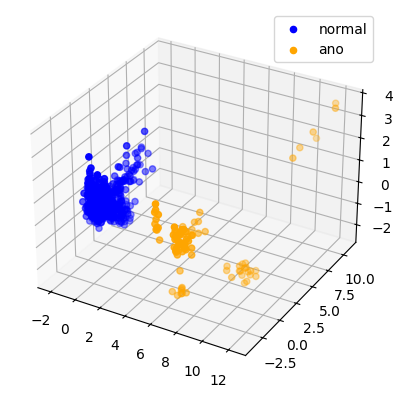

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reducerea dimensiunea datelor
Xpca = PCA(n_components=3).fit_transform(X)

# Indecși semnalelor normale și anomaliilor
idx_normal = y==0
idx_ano = y==1

# Afișarea datelor cu dimensiune redusă
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(Xpca[idx_normal,0], Xpca[idx_normal,1], Xpca[idx_normal,2], c='blue', label='normal')
ax.scatter(Xpca[idx_ano,0], Xpca[idx_ano,1], Xpca[idx_ano,2], c='orange', label='ano')

ax.legend()
plt.show()

### Împărțirea în setul de antrenare și cel de testare

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

## Local Outlier Factor

**Local Outlier Factor** (LOF) este o metodă de identificare a anomaliilor care se bazează pe ipoteza că semnalele normale se aglomerează în regiuni mai dense ale spațiului decât anomaliile.

Prin urmare, LOF calculează un scor de densitate locală pentru fiecare semnal, care este utilizat pentru a distinge între anomalii și semnalele normale:
*   semnalele cu scor de densitate locală asemănătoare cu cel al vecinilor vor fi etichetate ca semnale normale,
*   semnalele cu densitate locală semnificativ mai mică decât cea a vecinilor vor fi etichetate ca anomalii.

După cum obsevați, conceptul de densitate este legat de cel de vecinătate. LOF apelează la ideea de k-nearest neighbor pentru calculul densităților locale. Pentru a calcula densitatea locală, LOF se bazează pe distanțele dintre un semnal și cei mai apropiați k-vecini.

OBS: Implentările de mai jos nu sunt optimizate, dar urmăresc îndeaproape relațiile matematice care descriu algoritmul.

#### Calculul k-distance

Se definește k-distanța (**k-distance**) unui semnal $p$ ca distanța $d(p,o)$ dintre $p$ și un alt semnal $o$ astfel încât
*   pentru cel puțin k semnale $o' \in X \setminus \{p\}$, $d(p,o') \le d(p,o)$ și
*   pentru cel mult k-1 semnale $o' \in X \setminus \{p\}$, $d(p,o') < d(p,o)$.

Dându-se k-distanța semnalului $p$, se definește **vecinătatea de k-distanță** (*k-distance neighborhood*) a lui $p$ mulțimea de semnale aflate la o distanță mai mică decât *k-distance* de $p$,
	\begin{equation}
		N_k(p) = \{ q \in X \setminus \{p\} \mid d(p,q) \le \text{k-distance}(p)  \}
	\end{equation}

Pentru calculul k-distance vom utiliza metoda KNN implementată în `sklearn`.

În ce privește valoarea optimă a lui $k$, literatura sugerează că atunci când se cunoaște că numărul de anomalii din baza de date reprezintă $10\%$ din numărul de semnale, $k=20$ este o valoare potrivită, iar ea trebuie crescută în cazul în care procentul de anomalii este mai mare.

In [ ]:
from sklearn.neighbors import NearestNeighbors

k = 20
def perform_knn(X,k=20):
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(X)
    return knn.kneighbors(X)

knn = perform_knn(X_test, k)

# knn.kneigbors returnează atât lista de k-vecini ai fiecărui element din
# baza de date, cât și distanțele de la el la aceștia
distances = knn[0]
neighbors = knn[1]

# Verificați dimensiunile variabilelor knn, distances și neighbors și
# vizualizați conținutul lor
# WRITE YOUR IMPLEMENTATION HERE

print(np.shape(knn))
print(np.shape(distances))
print(np.shape(neighbors))

print(knn)
print(distances)
print(neighbors)

(2, 250, 20)
(250, 20)
(250, 20)
(array([[0.        , 0.22281454, 0.28383248, ..., 0.49750597, 0.49957971,
        0.50342203],
       [0.        , 0.97632014, 1.15477309, ..., 1.82124364, 1.87986916,
        1.89757126],
       [0.        , 0.28872294, 0.36695162, ..., 0.73407504, 0.73415202,
        0.73683255],
       ...,
       [0.        , 0.26079105, 0.30758293, ..., 0.48957997, 0.49220642,
        0.49427938],
       [0.        , 0.29856709, 0.31970866, ..., 0.57346376, 0.58116802,
        0.58428795],
       [0.        , 1.8022427 , 2.07826946, ..., 2.84466254, 2.89770716,
        2.92407732]]), array([[  0,  94, 154, ..., 155,  67,  21],
       [  1,  81, 128, ...,  56, 144, 179],
       [  2, 175,  97, ..., 216,  20,  46],
       ...,
       [247, 210,  59, ...,  53,   3,   0],
       [248, 246, 247, ...,  15,  46,   0],
       [249,  31, 204, ..., 100,  64, 142]]))
[[0.         0.22281454 0.28383248 ... 0.49750597 0.49957971 0.50342203]
 [0.         0.97632014 1.15477309 ..

### Calculul distanțelor locale de accesibilitate
Distanța de accesibilitate între două puncte $p$ și $o$ este
*   distanța dintre $p$ și $o$, dacă $p$ se află în afara k-vecinătății lui $o$
*   distanța dintre $p$ și k-vecinul său, altfel.

Se definește **distanța de accesibilitate** (*reachability distance*) a lui $p$ la $o$,
	\begin{equation}
		\text{reach-dist}_k(p,o) =  max(\text{k-distance}(o), d(p,o))
	\end{equation}

In [ ]:
def reach_dist(o_distances, dist_po):
    # o_distances: lista k-distanțelor de la o (vecinul lui p) la vecinii lui o
    # dist_po: distanța dintre p și o

    # Calculați k-distanța pentru semnalul o
    o_kdist = max(o_distances)

    # Calculați distanța de accesibilitate dintre p și o
    reach_dist = max(o_kdist,dist_po)   # WRITE YOUR IMPLEMENTATION HERE
    return reach_dist

### Calculul densităților locale de accesibilitate
Se definește **densitatea locală de accesibilitate** (local reachability density) a lui $p$,
		\begin{equation}
			lrd_k(p) = \left(\frac{\sum_{o \in N_k(p)}{\text{reach-dist}_k(p,o)}}{\vert N_k(p)\vert} \right)^{-1}
		\end{equation}

In [ ]:
def  lrd(p, knn):
    # p, indicele semnalului pentru care se dorește calcularea densității locale
    # knn, rezultatul apelului algoritmului KNN
    p_distances = knn[0,int(p),:]
    p_neighbors = knn[1,int(p),:]
    sum_reach_distances = 0
    for idx_o, o in enumerate(p_neighbors):
        # Selectați lista distanțelor semnalului o față de vecinii săi
        o_distances = knn[0][int(o),:]  # WRITE YOUR IMPLEMENTATION HERE

        # Determinați distanța dintre p și o
        dist_po = p_distances[idx_o] # WRITE YOUR IMPLEMENTATION HERE

        # Calculați distanța de accesibilitate de la semnalul p la vecinul o
        o_reach_dist = reach_dist(o_distances, dist_po)
        sum_reach_distances = sum_reach_distances + o_reach_dist

    # Calculează media distanțelor de accesibilitate
    avg_reach_distance = sum_reach_distances/k
    # Calculează densitatea locală de accesibilitate
    lrd = 1.0/avg_reach_distance
    return lrd

### Calculul scorului LOF

Scorul LOF al unui semnal reprezintă media densităților locale de accesibilitate ale vecinilor semnalului raportată la densitatea locală de accesibilitate a respectivului semnal.

Se definește **scorul LOF** al unui semnal $p$,
		\begin{equation}
			LOF_k(p) = \frac{\sum_{o \in N_k(p)}{\frac{lrd_k(o)}{lrd_k(p)}}}{\vert N_k(p)\vert}
		\end{equation}

*   Dacă un semnal are $LOF_k(p) > 1$, atunci este anomalie (are densitatea locală mai mică decât vecinii).
*   Dacă un semnal are $LOF_k(p) < 1$, atunci este semnal normal.




In [ ]:
def local_outlier_factor(p, knn, k):
# Calculați vecinii lui p
    p_neighbors = knn[1,int(p),:]
    # Calculați densitatea de accesibilitate pentru semnalul p
    p_lrd = lrd(p, knn)
    # Calculați distanța de accesibilitate pentru toți vecinii lui p
    sum_lrd_p_neigbors = 0
    for o in p_neighbors:
        o_lrd = lrd(o,knn)  # WRITE YOUR IMPLEMENTATION HERE
        sum_lrd_p_neigbors = sum_lrd_p_neigbors + o_lrd
    # Calculați scorul LOF
    lof = sum_lrd_p_neigbors / (k*p_lrd) # WRITE YOUR IMPLEMENTATION HERE
    return lof

### Testare
Algoritmul LOF nu presupune etape distincte de antrenare și testare.
El calculează scorurile de anomalie pe setul de date primit la intrare.
Pentru a putea compara rezultatele cu alți algoritmi, veți aplica algoritmul LOF doar pe datele de testare.

In [ ]:
k = 20
# Transformarea variabilei knn în numpy array
knn = np.array(knn)

# Calculează scorul LOF pentru fiecare semnal
lof = []
for i in range(X_test.shape[0]):
    lof_i = local_outlier_factor(i,knn,k) # WRITE YOUR IMPLEMENTATION HERE
    lof.append(lof_i)

# Etichetele semnalelor sunt scorurile lor LOF
y_score_LOF = np.array(lof)

### Verificare
Algoritmul LOF este implementat în biblioteca `sklearn`.

OBS: Implementarea din `sklearn` include posibilitatea antrenării și testării algoritmului pe seturi separate, metoda fiind folosită pentru *novelty detection* (atunci când setul de antrenare și cel de testare diferă).
Pentru a putea compara rezultatele cu cele obținute de soluția voastră (standard) nu utilizați opțiunea aceasta aici.
Însă comparația cu alți algoritmi (care prin construcție trebuie antrenați și testați pe seturi diferite) este mai justă dacă se utilizează opțiunea *novelty detection*.

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=k)
y_score_LOF_sklearn = clf.fit_predict(X_test)

## Evaluarea Performanțelor

Metodele de antrenare din `sklearn` generează etichetele în modul următor:
*   Semnalele normale sunt etichetate cu 1.
*   Anomaliile sunt etichetate cu -1.

În baza de date, precum și în implementarea voastră, semnalele normale sunt etichetate cu 0, iar anomaliile cu 1.

Pentru a putea evalua algoritmii, e nevoie de schimbarea etichetelor generate de metodele `sklearn` pentru a corespunde cu etichetele din baza de date.

De asemenea, implementarea voastră a algoritmului LOF returnează scoruri de anomalie și nu etichete binare, ca implementarea `sklearn`.
Ele se pot converti în etichete: un semnal cu un scor mai mare ca 1 este considerat anomalie, iar dacă scorul este mai mic ca 1, semnalul poate fi interpretat ca normal.


In [ ]:
# Modificați etichetele obținute de algoritmul LOF al sklearn
# pentru a corespunde etichetelor din baza de date

#copie_y_score_LOF_sklearn = y_score_LOF_sklearn

print(y_score_LOF_sklearn)

y_score_LOF_sklearn = (1 - y_score_LOF_sklearn)/2 # WRITE YOUR IMPLEMENTATION HERE

# Convertiți scorul LOF din implementarea voastră în etichete binare
#copie_y_score_LOF = y_score_LOF# WRITE YOUR IMPLEMENTATION HERE

#print(y_score_LOF)
y_score_LOF = (y_score_LOF > 1).astype(int)

print(y_score_LOF_sklearn)

print( np.array_equal(y_score_LOF,y_score_LOF_sklearn))
# Verificați dacă utilizând metoda LOF din sklearn obțineți aceleași valori
# ale scorurilor LOF ca în implementarea voastră
# WRITE YOUR IMPLEMENTATION HERE

# OBS: diferențele apar, în principal, datorită pragului de densitate utilizat
# pentru etichetarea anomaliilor: în implementarea voastră pragrul este 1
# (conform metodei), iar în implementarea sklearn este 1.5

[ 1  1  1  1  1 -1  1  1  1  1 -1 -1  1  1 -1  1  1  1  1  1  1  1  1  1
  1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1
  1  1  1  1 -1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1 -1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1 -1  1  1  1
  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1 -1  1 -1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1 -1
  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1
  1  1  1 -1  1 -1  1  1  1  1  1  1  1 -1  1  1  1 -1  1  1 -1  1  1  1
  1  1  1 -1  1  1  1  1  1  1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1
  1  1  1  1  1  1 -1  1 -1  1 -1 -1  1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1 -1  1  1  1  1  1 -1]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 

Pentru evaluarea performanțelor algoritmilor vom utiliza metrica Area under Curve Receiver Operating Characteristic (ROC AUC).

In [ ]:
from sklearn.metrics import roc_auc_score

# Calculul scorurilor AUC pentru ambele implementări (sklearn și a voastră)
auc_lof_sklearn = roc_auc_score(y_test, y_score_LOF_sklearn)
auc_lof = roc_auc_score(y_test, y_score_LOF)#WRITE YOUR IMPLEMENTATION HERE

print(auc_lof_sklearn)
print(auc_lof)

# Afișați numărul de semnale etichetate diferit de cele două implementări
# WRITE YOUR IMPLEMENTATION HERE

semnale_et_dif = 0

for i in range(len(y_score_LOF)):
    if y_score_LOF_sklearn[i] != y_score_LOF[i]:
        semnale_et_dif = semnale_et_dif + 1

print(semnale_et_dif)





0.7184782608695652
0.6130434782608696
161


## Algoritmul Isolation Forest

Pentru a pune în context rezultatele obținute cu algoritmul LOF, îl veți compara cu algoritmul Isolation Forest (IForest), implementat în `sklearn`.

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)
clf = IsolationForest(max_samples=256)
clf.fit(X_train)
y_score_IF = clf.predict(X_test)

# Modificați etichetele obținute de IForest sklearn pentru a corespunde
# etichetelor din baza de date, așa cum ați făcut mai sus pentru LOF
y_score_IF = # WRITE YOUR IMPLEMENTATION HERE

auc_IF = roc_auc_score(y_test, y_score_IF)

print(auc_IF)

SyntaxError: invalid syntax (ipython-input-2432412897.py, line 11)

## Tema (în laborator)
Aplicați pașii de mai sus și pentru cea de-a doua bază de date, `local_Stamps.npz`.

Comparați și comentați rezultatele.